# HTM Theory and NuPIC Walkthrough

This notebook includes a description of the basic building blocks of HTM theory and walks through examples using the implementations in NuPIC. The goal is to provide a basic understanding of how the algorithms work, the properties of the algorithms, and how to use the implementations in NuPIC. The notebook is split into three broad sections:

- Encoding - How to turn different data types into Sparse Distributed Representations (SDRs).
- Modeling - Creating a predictive model of the data using Spatial Pooling and Temporal Memory.
- Classification - Turning the sequence memory state into predictions and anomaly detection.

In [1]:
# Some misc. set up. Run this first!
%matplotlib inline

import datetime
import json
import random

import matplotlib.pyplot as plt
import numpy
from pkg_resources import resource_filename

OFF = u"\u25CB"
ON = u"\u25CF"
PREDICTED = u"\u235F"
def displaySDR(bits, label=None, width=None):
    """Display the bits.
    
    :param bits: array of bits
    """
    if label is not None:
        if width is not None:
            label = str(label).ljust(width)
        label = "{} =".format(label)
        print label,
    for b in bits:
        if b:
            print ON,
        else:
            print OFF,
    print

# Encoding for HTM Systems

Encoding is the process of turning arbitrary data types into Sparse Distributed Representations (SDRs). SDRs capture the semantic aspects of the data in a common format that the HTM algorithms understand. This process is analogous to sensory organs that send neural signals into the brain. For a detailed explanation of encoding data, see the white paper *Encoding Data for HTM Systems*:

http://arxiv.org/abs/1602.05925

## Numeric Values

What are the semantic characteristics that we care about? Values that are close are similar while values that are far apart are not.

In [2]:
from nupic.encoders import ScalarEncoder

ScalarEncoder?


In [9]:
# 22 bits with 3 active representing values 0 to 100
# clipInput=True makes values >100 encode the same as 100 (instead of throwing a ValueError)
# forced=True allows small values for `n` and `w`
enc = ScalarEncoder(n=22, w=3, minval=2.5, maxval=97.5, clipInput=True, forced=True)

for i in xrange(3, 6):
    displaySDR(enc.encode(i), i)


3 = ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
4 = ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
5 = ○ ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○


In [6]:
def overlap(a, b):
    return numpy.logical_and(a, b).sum()

print "Overlap(3, 4):", overlap(enc.encode(3), enc.encode(4))
print "Overlap(3, 5):", overlap(enc.encode(3), enc.encode(5))

Overlap(3, 4): 3
Overlap(3, 5): 2


In [7]:
# Encode maxval
displaySDR(enc.encode(100), 100, 4)
# See that any larger number gets the same encoding
displaySDR(enc.encode(1000), 1000)

100  = ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ●
1000 = ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ●


In [10]:
from nupic.encoders.random_distributed_scalar import RandomDistributedScalarEncoder

RandomDistributedScalarEncoder?

In [13]:
# 21 bits with 3 active with buckets of size 5
rdse = RandomDistributedScalarEncoder(n=21, w=3, resolution=5, offset=2.5)

for i in xrange(3, 6):
    displaySDR(rdse.encode(i), i, 4)

print
displaySDR(rdse.encode(100), 100, 4)
displaySDR(rdse.encode(1000), 1000)

3    = ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ○ ● ●
4    = ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ○ ● ●
5    = ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ○ ●

100  = ○ ● ● ○ ○ ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
1000 = ○ ○ ○ ● ○ ○ ○ ○ ● ○ ○ ○ ○ ○ ○ ● ○ ○ ○ ○ ○


## Dates and Times

The semantic characteristics of dates and times that matter can differ from one application to another. Sometimes you care about the time of day, sometimes the day of the week, etc. We want the encoder to be able to handle each of these cases, providing overlap between values if they are similar with regard to the characteristic that is selected.

In [14]:
from nupic.encoders.date import DateEncoder

DateEncoder?

In [15]:
de = DateEncoder(season=5)

now = datetime.datetime.strptime("2016-03-17 18:30:00", "%Y-%m-%d %H:%M:%S")
displaySDR(de.encode(now), "now", 10)

nextMonth = datetime.datetime.strptime("2016-04-17 13:08:58", "%Y-%m-%d %H:%M:%S")
displaySDR(de.encode(nextMonth), "next month")

xmas = datetime.datetime.strptime("2016-12-25 13:08:58", "%Y-%m-%d %H:%M:%S")
displaySDR(de.encode(xmas), "xmas", 10)

now        = ○ ○ ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
next month = ○ ○ ○ ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
xmas       = ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ●


## Categories

If we want to encode categories with no specific ordering or relation, when do we want two different values to have overlap? We only want overlap for identical categories. Different categories should have completely different encodings.

In [16]:
from nupic.encoders.category import CategoryEncoder

categories = ("cat", "dog", "monkey", "slow loris")
encoder = CategoryEncoder(w=3, categoryList=categories, forced=True)

cat = encoder.encode("cat")
displaySDR(cat, "cat", 10)

dog = encoder.encode("dog")
displaySDR(dog, "dog", 10)

monkey = encoder.encode("monkey")
displaySDR(monkey, "monkey", 10)

loris = encoder.encode("slow loris")
displaySDR(loris, "slow loris")

cat        = ○ ○ ○ ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○
dog        = ○ ○ ○ ○ ○ ○ ● ● ● ○ ○ ○ ○ ○ ○
monkey     = ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ○ ○ ○
slow loris = ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ●


In [17]:
displaySDR(encoder.encode(None), "None")

None = ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○


In [18]:
displaySDR(encoder.encode("unknown"), "unknown")

unknown = ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○


In [19]:
# Encoders can attempt to decode an SDR into one of the categories.
print encoder.decode(cat)

({'category': ([(1, 1)], 'cat')}, ['category'])


In [20]:
# This can work even if the SDR is ambiguous.
catdog = numpy.array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])
print encoder.decode(catdog)

({'category': ([(1, 2)], 'cat, dog')}, ['category'])


# Spatial Pooling

Creates invariant spatial representations for data. The pooling process creates a fixed-sparsity SDR that is tolerant to noise. Like encoding, similar inputs will produce similar (overlapping) outputs (active columns, in this case).

The algorithm is fairly simple:

- Each column has a potential pool of inputs that it can connect to.
- Each potential connection has a permanence that can change with learning.
- If a column's permanence for a given input bit is above a threshold, we treat it as connected.
- For a new input, each column counts the number of active input bits that it is connected to and the top X columns "win" (become active).

When learning is enabled, active columns will:

- Increment permanences for the active input bits (whether they are currently connected or not).
- Decrement permanences for input bits that are not active.

To ensure that all columns learn to represent useful patterns, columns get a boosting factor the longer they are inactive. This boosting factor is multiplied by the sum of their active connected inputs prior to the competition step where the winning columns are selected.

In [21]:
from nupic.research.spatial_pooler import SpatialPooler

print SpatialPooler?

In [ ]:
print SpatialPooler

In [22]:
print len(cat)
displaySDR(cat)

15
○ ○ ○ ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○


In [24]:
sp = SpatialPooler(inputDimensions=(15,),
                   columnDimensions=(4,),
                   potentialRadius=15,
                   numActiveColumnsPerInhArea=1,
                   globalInhibition=True,
                   synPermActiveInc=0.03,
                   potentialPct=1.0,
                   seed=1)

for column in xrange(4):
    connected = numpy.zeros((15,), dtype="int")
    sp.getConnectedSynapses(column, connected)
    displaySDR(connected, "Column {} connections".format(column))

Column 0 connections = ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ○
Column 1 connections = ● ● ● ● ○ ○ ○ ○ ● ● ○ ● ○ ● ●
Column 2 connections = ○ ● ● ● ● ○ ● ○ ○ ● ● ○ ● ○ ○
Column 3 connections = ● ○ ● ○ ● ○ ● ● ○ ○ ● ○ ● ○ ●


In [25]:
output = numpy.zeros((4,), dtype="int")
sp.compute(cat, learn=True, activeArray=output)
displaySDR(output, "Active columns")

Active columns = ○ ○ ● ○


In [26]:
# Train on cat a bunch of times to see how the connections change.
for _ in xrange(30):
    sp.compute(cat, learn=True, activeArray=output)

In [27]:
# Now print the column connections.
for column in xrange(4):
    connected = numpy.zeros((15,), dtype="int")
    sp.getConnectedSynapses(column, connected)
    displaySDR(connected, "Column {} connections".format(column))
    if column == 2:
        print u"             New connection:     \u2191        \u2191   Lost connection"



Column 0 connections = ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ○
Column 1 connections = ● ● ● ● ○ ○ ○ ○ ● ● ○ ● ○ ● ●
Column 2 connections = ○ ● ● ● ● ● ● ○ ○ ● ○ ○ ● ○ ○
             New connection:     ↑        ↑   Lost connection
Column 3 connections = ● ○ ● ○ ● ○ ● ● ○ ○ ● ○ ● ○ ●


In [28]:
# Now train on all four categories to see what happens.
for _ in xrange(200):
    sp.compute(cat, learn=True, activeArray=output)
    sp.compute(dog, learn=True, activeArray=output)
    sp.compute(monkey, learn=True, activeArray=output)
    sp.compute(loris, learn=True, activeArray=output)

In [29]:
# Show that each column has adapted to represent one of the categories completely.
for column in xrange(4):
    connected = numpy.zeros((15,), dtype="int")
    sp.getConnectedSynapses(column, connected)
    displaySDR(connected, "Column {} connections".format(column))

Column 0 connections = ● ● ● ○ ○ ○ ○ ○ ○ ● ○ ● ● ● ○
Column 1 connections = ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ○ ○ ○
Column 2 connections = ○ ○ ○ ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○
Column 3 connections = ○ ○ ○ ○ ○ ○ ● ● ● ○ ○ ○ ● ● ●


In [30]:
noisyCat = numpy.zeros((15,), dtype="uint32")
noisyCat[3] = 1
noisyCat[4] = 1
# This is part of dog!
noisyCat[6] = 1
displaySDR(noisyCat)

○ ○ ○ ● ● ○ ● ○ ○ ○ ○ ○ ○ ○ ○


In [31]:
sp.compute(noisyCat, learn=False, activeArray=output)
displaySDR(output, "Active columns")  # matches cat!

Active columns = ○ ○ ● ○


To learn more, see:

- [SP Visualization](https://github.com/iandanforth/spviewer) - pygame visualization of SP on simple images
- [nupic.vision](https://github.com/numenta/nupic.vision) - includes MNIST example

# Temporal Memory (a.k.a. Sequence Memory)

This section starts with some static images showing how the TM works. After these, we will create an actual TM and print the state out at each step.

References:

- [HTM Neuron Paper](http://arxiv.org/abs/1511.00083)

----

![Feedforward inputs active a sparse set of cells. Columns burst unless a cell in the column is already depolarized, in which case only that cell becomes active and the rest are inhibited.](images/tm1.png)

----

![Cells in each active column create new segments with connections from the previously active cells. This segments form the basis for prediction and, when enough pre-synaptic cells are active, the cell goes into a predicted (deporalized) state.](images/tm2.png)

----

![The representation captures ambiguity and can make multiple simultaneous predictions.](images/tm3.png)

----

## Computational Properties of HTM Sequence Memory

1. On-line learning
2. High-order representations
    - For example: sequences “ABCD” vs. “XBCY”
3. Multiple simultaneous predictions
    - For example: “BC” predicts both “D” and “Y”
4. Fully local and unsupervised learning rules
5. Extremely robust
    - Tolerant to >40% noise and faults
6. High capacity

In [32]:
from nupic.research.temporal_memory import TemporalMemory

TemporalMemory?

In [33]:
def displayInput(a, columns):
    """Display the input bits.
    
    :param a: array of indices of active columns
    :param columns: the total number of columns
    """
    l = [0] * columns
    for i in a:
        l[i] = 1
    for v in l:
        if v:
            print ON,
        else:
            print OFF,
    print

In [34]:
# Step 1: Create Temporal Memory instance with appropriate parameters

COLUMNS = 50
CELLS_PER_COLUMN = 6

tm = TemporalMemory(
    columnDimensions=(COLUMNS,), cellsPerColumn=CELLS_PER_COLUMN,
    initialPermanence=0.5, connectedPermanence=0.5,
    minThreshold=10, maxNewSynapseCount=10,
    permanenceIncrement=0.1, permanenceDecrement=0.0,
    activationThreshold=8)

In [35]:
# Step 2: Create input vectors to feed to the Temporal Memory.
  
x = []
for i in xrange(5):
    x.append(set((i*10) + j for j in xrange(10)))
    
order = range(5)
r = random.Random(42)
r.shuffle(order)
x = [x[i] for i in order]
for i in xrange(5):
    print "Input #{}:".format(i)
    displayInput(x[i], COLUMNS)

Input #0:
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
Input #1:
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
Input #2:
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ●
Input #3:
● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
Input #4:
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○


In [36]:
# Step 3: Send this simple sequence to the Temporal Memory for learning.
# Repeat the sequence 10 times to ensure it is learned.

for i in range(10):

    # Send each letter in the sequence in order
    for j in range(5):

        # The compute method performs one step of learning and/or inference. Note:
        # here we just perform learning but you can perform prediction/inference and
        # learning in the same step if you want (online learning).
        tm.compute(x[j], learn=True)

        # This function prints the segments associated with every cell.
        # If you really want to understand the TM, uncomment this line. By following
        # every step you can get an excellent understanding for exactly how the TM
        # learns.
        #tm.printCells()

    # The reset command tells the TM that a sequence just ended and essentially
    # zeros out all the states. It is not strictly necessary but it's a bit
    # messier without resets, and the TM learns quicker with resets.
    tm.reset()

In [37]:
def displayCells(columns, cellsPerColumn, active, predicted):
    rows = []
    for _ in xrange(cellsPerColumn):
        rows.append([OFF] * columns)
    for i in active:
        r = i % cellsPerColumn
        c = i / cellsPerColumn
        rows[r][c] = ON
    for i in predicted:
        r = i % cellsPerColumn
        c = i / cellsPerColumn
        rows[r][c] = PREDICTED
    for r in rows:
        for i in r:
            print i,
        print
        
def displayTM(tm):
    displayCells(tm.numberOfColumns(), tm.getCellsPerColumn(), tm.getActiveCells(), tm.getPredictiveCells())

In [38]:
# Step 4: Send the same sequence of vectors and look at predictions made by
# Temporal Memory.

tm.reset()
for j in range(5):
    print "\n\n--------","ABCDE"[j],"-----------"
    print
    
    #previouslyPredictedCells = tm.getPredictiveCells()

    # Send each vector to the TM, with learning turned off
    tm.compute(x[j], learn=False)

    displayTM(tm)



-------- A -----------

○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ○ ○ ⍟ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ○ ○ ○ ⍟ ⍟ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ○ ⍟ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ⍟ ⍟ ⍟ ○ ○ ○ ○ ○ ○ ⍟ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ● ● ● ● ● ● ● ● ○ ○ ○ ⍟ ○ ⍟ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○


-------- B -----------

○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ⍟ ○ ○ ⍟ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ⍟ ⍟ ○ ⍟ ○ ○ ○ ○ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ● ● ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ⍟ ○ ○ ⍟ ○ ○ ○ ○
○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ ○ 

# Anomaly Scores

NuPIC includes logic for computing several types of anomaly scores. The raw anomaly score is a simple per-record estimate of how expected the input was. It is computed as the fraction of active columns that were not predicted. In the example above, the anomaly score would have been `1.0` when `A` was presented and then `0.0` for the following patterns since each of the following patterns were completely predicted.

Because the Temporal Memory makes multiple simultaneous predictions, the anomaly score can still be low when there is uncertainty if the outcome is one of the learned sequences.

There is an additional process for computing the likelihood that the data is anomalous. This process normalizes the anomaly scores to the specific data so that it still produces useful scores for inherently noisy data streams. The process consists of:

1. Smoothing the raw anomaly scores with a moving average.
2. Maintaining an estimate of the mean and standard deviation of the smoothed scores for some history.
3. Comparing the current smoothed score to the distribution to estimate the probability that the data is normal.

The resulting anomaly likelihood values can then be thresholded to determine whether to consider the data anomalous. Typical threshold values are `0.9999` for data that is somewhat likely and `0.99999` for data that is very likely to be anomalous.

The exact computation can be found in the anomaly-related files here:

https://github.com/numenta/nupic/tree/master/src/nupic/algorithms

# Networks and Regions

The next example uses the Network API to simplify building a model. The data being modeled is the energy usage in a gym. The Network API provides a way to declaratively specify the organization of the encoders, algorithms, and classifiers that enable the API to propogate data through the components so that you don't have to do so manually.

For this example, we use a utility function, `createTemporalAnomaly`, to handle the network creation. There are [examples of constructing networks in NuPIC](https://github.com/numenta/nupic/tree/master/examples/network).

In [39]:
from nupic.engine.common_networks import createTemporalAnomaly

RECORD_PARAMS = {
    "inputFilePath": resource_filename(
        "nupic.datafiles", "extra/hotgym/rec-center-hourly.csv"),
    "scalarEncoderArgs": {
        "w": 21,
        "minval": 0.0,
        "maxval": 100.0,
        "periodic": False,
        "n": 50,
        "name": "consumption",
        "verbosity": 0,
        "clipInput": True,
        "forced": False,
    },
    "dateEncoderArgs": {
        "season": 0,
        "dayOfWeek": 0,
        "weekend": 0,
        "holiday": 0,
        "timeOfDay": (21, 9.5),
        "customDays": 0,
        "name": "timestamp",
        "forced": True
    },
}

n = createTemporalAnomaly(RECORD_PARAMS)
sensorRegion = n.regions["sensor"]
anomalyRegion = n.regions["anomalyRegion"]

data = []
rawAnomalyScores = []
for _ in xrange(3000):
    n.run(1)
    data.append(sensorRegion.getOutputData("sourceOut")[0])
    rawAnomalyScores.append(anomalyRegion.getOutputData("rawAnomalyScore")[0])


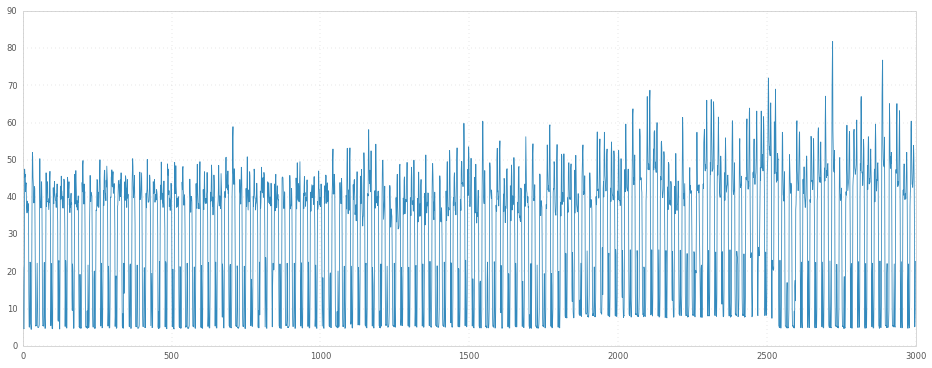

In [40]:
plt.figure(figsize=(16, 6))
plt.plot(xrange(len(data)), data)

<Container object of 3000 artists>

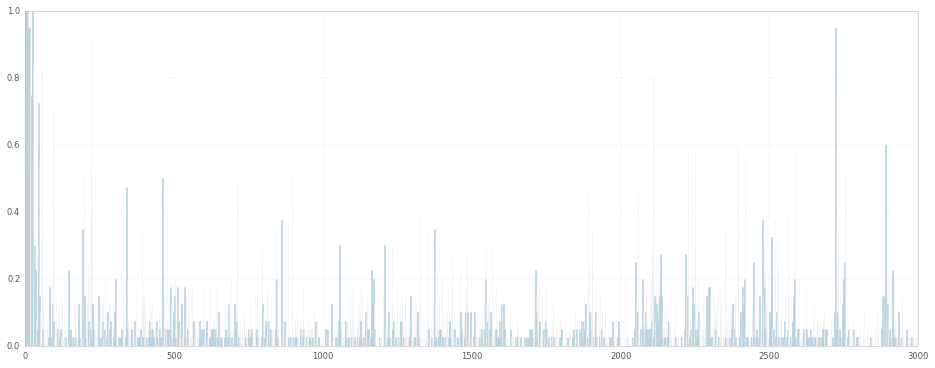

In [41]:
plt.figure(figsize=(16, 6))
plt.bar(xrange(len(rawAnomalyScores)), rawAnomalyScores)

While the raw anomaly scores give useful information, they aren't very actionable. Setting a threshold on the raw scores may produce many false positives. This becomes especially problematic with very noisy data where the raw scores may regularly hit `1.0`. We want to ensure that we mark the data as anomalous only when there is substantial deviation from the normal behavior so we compute the anomaly likelihood.

**Note**: There is a burn in period in which the anomaly likelihood is reported as `0.5` while the algorithms are still learning the sequences in the data and the confidence in the likelihood score is low.

In [42]:
from nupic.algorithms.anomaly_likelihood import AnomalyLikelihood

anomalyLikelihoods = []
helper = AnomalyLikelihood()

for value, rawScore in zip(data, rawAnomalyScores):
    anomalyLikelihoods.append(helper.anomalyProbability(value, rawScore, None))


<Container object of 3000 artists>

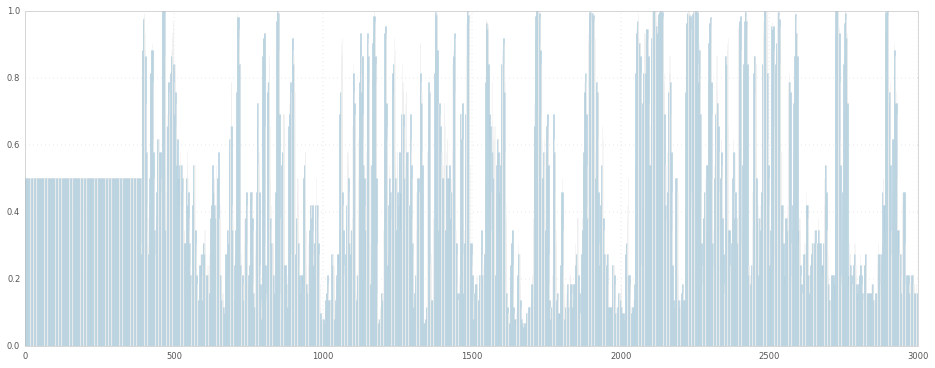

In [43]:
plt.figure(figsize=(16, 6))
plt.bar(xrange(len(anomalyLikelihoods)), anomalyLikelihoods)

<Container object of 3000 artists>

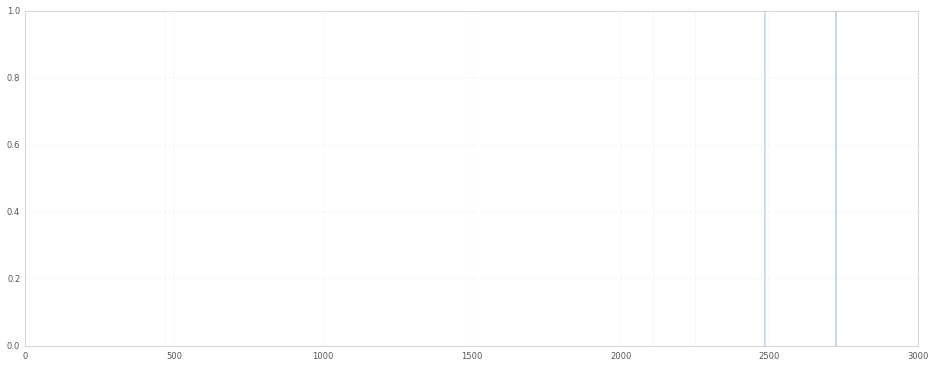

In [44]:
anomalies = []
for anomalyLikelihood in anomalyLikelihoods:
    if anomalyLikelihood > 0.99999:
        anomalies.append(1.0)
    else:
        # Note: For some reason the chart doesn't display correctly if 0.0 is used here.
        anomalies.append(0.0000001)

plt.figure(figsize=(16, 6))
plt.bar(xrange(len(anomalies)), anomalies)

<Container object of 800 artists>

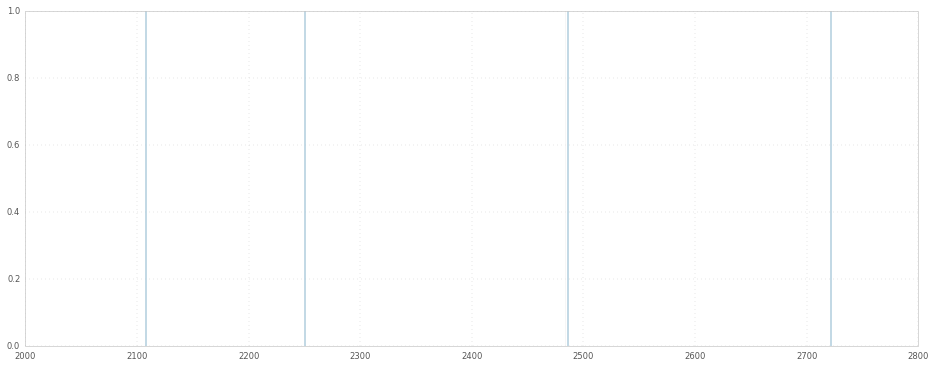

In [45]:
plt.figure(figsize=(16, 6))
plt.bar(xrange(2000, 2800), anomalies[2000:2800])

# Prediction

Another way to utilize the model is to create predictions based on the internal state of the Temporal Memory. NuPIC includes a classifier specifically built for this. The Python implementation is `nupic.algorithms.CLAClassifier.CLAClassifier` and the C++ implementation is `nupic.bindings.algorithms.FastCLAClassifier`. These classifiers can predict any number of steps into the future.

These classifiers take three input values:

- The Temporal Memory state to classify.
- The current value for the predicted field.
- The bucket index of the current value for the predicted field.

## Learning

The classifier stores the Temporal Memory state for however many steps the classifier is configured to predict. So for a classifier configured to predict X steps ahead, the TM state will be stored for X steps. For each bit in the TM state, the classifier keeps a weight for each bucket index. At each step, the classifier updates the weight for the current active bucket index for each active bit in the Temporal Memory state from X steps ago.

Additionally, an exponential moving average of the actual values is kept for each bucket. The moving average for the current active bucket is updated at each step.

## Predicting

The prediction consists of selecting a set of predicted bucket indices and then determining the real value to use for the predictions. Each active bit contributes a vote for the bucket that it has the highest weight for. The buckets are assigned prediction probabilities based on how many votes they receive.

For a given predicted bucket, the predicted value is simply the currently stored moving average for that bucket.

# Prediction Example

This example uses the same model as the last example but we additionally create a classifier that we use to make predictions for 1 and 5 steps ahead. The most likely prediction is stored for each time step so we can compare the actual and predicted values.

In [46]:
from nupic.bindings.algorithms import FastCLAClassifier

classifier = FastCLAClassifier(steps=(1, 5))

net = createTemporalAnomaly(RECORD_PARAMS)
sensorRegion = net.regions["sensor"]
temporalMemoryRegion = net.regions["temporalPoolerRegion"]

data = []
actualValues = []
predictions1 = [0.0]
predictions5 = [0.0] * 5
for i in xrange(800):
    net.run(1)
    actualValue = float(sensorRegion.getOutputData("sourceOut")[0])
    actualValues.append(actualValue)
    activeCells = temporalMemoryRegion.getOutputData("bottomUpOut").nonzero()[0]
    bucketIdx = sensorRegion.getSelf().encoder.encoders[0][1].getBucketIndices(actualValue)[0]
    
    results = classifier.compute(i, activeCells,
                                 {"bucketIdx": bucketIdx, "actValue": actualValue}, True, True)
    
    data.append(actualValue)
    mostLikely1Step = sorted(zip(results[1], results["actualValues"]))[-1][1]
    predictions1.append(mostLikely1Step)
    mostLikely5Step = sorted(zip(results[5], results["actualValues"]))[-1][1]
    predictions5.append(mostLikely5Step)


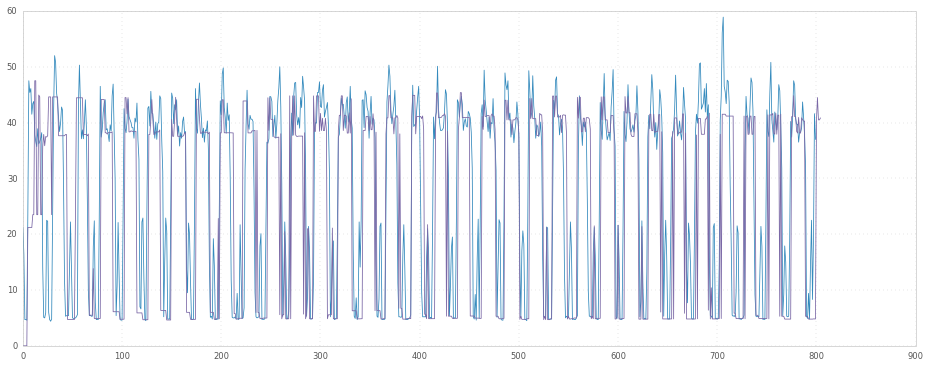

In [47]:
plt.figure(figsize=(16, 6))
plt.plot(xrange(len(actualValues)), actualValues, "", xrange(len(predictions5)), predictions5, "")

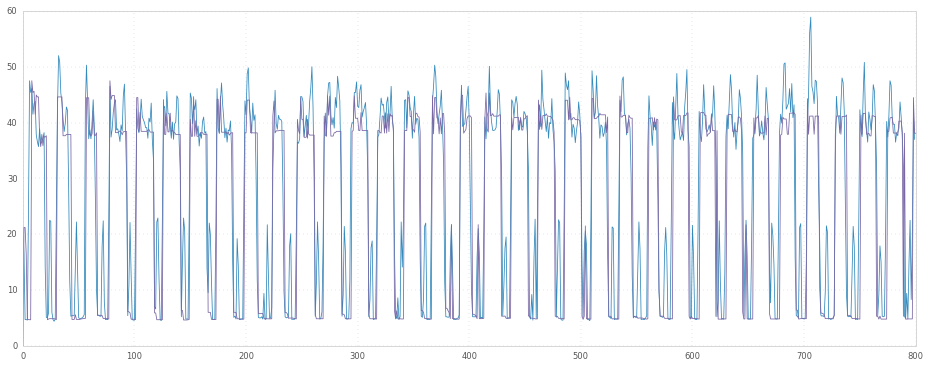

In [48]:
plt.figure(figsize=(16, 6))
plt.plot(xrange(len(actualValues)), actualValues, "", xrange(len(predictions1)), predictions1, "")

# Summary

## Encoding

Capture the semantic characteristics of the data through overlapping SDRs.

## Modeling

- Spatial Pooling
- Temporal Memory

## Classification

- Anomaly Detection - raw anomaly scores & anomaly likelihood
- Prediction - CLAClassifier

# End

# Supplemental Material

## Online Prediction Framework

* CLAModel
* OPF Client
* Swarming

## CLAModel

From `examples/opf/clients/hotgym/simple/hotgym.py`

# Model Parameters

`MODEL_PARAMS` have all of the parameters for the CLA model and subcomponents

In [ ]:
# Model Params!
MODEL_PARAMS = {
    # Type of model that the rest of these parameters apply to.
    'model': "CLA",

    # Version that specifies the format of the config.
    'version': 1,

    # Intermediate variables used to compute fields in modelParams and also
    # referenced from the control section.
    'aggregationInfo': {   'days': 0,
        'fields': [('consumption', 'sum')],
        'hours': 1,
        'microseconds': 0,
        'milliseconds': 0,
        'minutes': 0,
        'months': 0,
        'seconds': 0,
        'weeks': 0,
        'years': 0},

    'predictAheadTime': None,

    # Model parameter dictionary.
    'modelParams': {
        # The type of inference that this model will perform
        'inferenceType': 'TemporalMultiStep',

        'sensorParams': {
            # Sensor diagnostic output verbosity control;
            # if > 0: sensor region will print out on screen what it's sensing
            # at each step 0: silent; >=1: some info; >=2: more info;
            # >=3: even more info (see compute() in py/regions/RecordSensor.py)
            'verbosity' : 0,

            # Include the encoders we use
            'encoders': {
                u'timestamp_timeOfDay': {
                    'fieldname': u'timestamp',
                    'name': u'timestamp_timeOfDay',
                    'timeOfDay': (21, 0.5),
                    'type': 'DateEncoder'
                },
                u'timestamp_dayOfWeek': None,
                u'timestamp_weekend': None,
                u'consumption': {
                    'clipInput': True,
                    'fieldname': u'consumption',
                    'maxval': 100.0,
                    'minval': 0.0,
                    'n': 50,
                    'name': u'c1',
                    'type': 'ScalarEncoder',
                    'w': 21
                },
            },

            # A dictionary specifying the period for automatically-generated
            # resets from a RecordSensor;
            #
            # None = disable automatically-generated resets (also disabled if
            # all of the specified values evaluate to 0).
            # Valid keys is the desired combination of the following:
            #   days, hours, minutes, seconds, milliseconds, microseconds, weeks
            #
            # Example for 1.5 days: sensorAutoReset = dict(days=1,hours=12),
            #
            # (value generated from SENSOR_AUTO_RESET)
            'sensorAutoReset' : None,
        },

        'spEnable': True,

        'spParams': {
            # SP diagnostic output verbosity control;
            # 0: silent; >=1: some info; >=2: more info;
            'spVerbosity' : 0,

            # Spatial Pooler implementation selector, see getSPClass
            # in py/regions/SPRegion.py for details
            # 'py' (default), 'cpp' (speed optimized, new)
            'spatialImp' : 'cpp',

            'globalInhibition': 1,

            # Number of cell columns in the cortical region (same number for
            # SP and TP)
            # (see also tpNCellsPerCol)
            'columnCount': 2048,

            'inputWidth': 0,

            # SP inhibition control (absolute value);
            # Maximum number of active columns in the SP region's output (when
            # there are more, the weaker ones are suppressed)
            'numActiveColumnsPerInhArea': 40,

            'seed': 1956,

            # potentialPct
            # What percent of the columns's receptive field is available
            # for potential synapses. At initialization time, we will
            # choose potentialPct * (2*potentialRadius+1)^2
            'potentialPct': 0.5,

            # The default connected threshold. Any synapse whose
            # permanence value is above the connected threshold is
            # a "connected synapse", meaning it can contribute to the
            # cell's firing. Typical value is 0.10. Cells whose activity
            # level before inhibition falls below minDutyCycleBeforeInh
            # will have their own internal synPermConnectedCell
            # threshold set below this default value.
            # (This concept applies to both SP and TP and so 'cells'
            # is correct here as opposed to 'columns')
            'synPermConnected': 0.1,

            'synPermActiveInc': 0.1,

            'synPermInactiveDec': 0.005,
        },

        # Controls whether TP is enabled or disabled;
        # TP is necessary for making temporal predictions, such as predicting
        # the next inputs.  Without TP, the model is only capable of
        # reconstructing missing sensor inputs (via SP).
        'tpEnable' : True,

        'tpParams': {
            # TP diagnostic output verbosity control;
            # 0: silent; [1..6]: increasing levels of verbosity
            # (see verbosity in nupic/trunk/py/nupic/research/TP.py and TP10X*.py)
            'verbosity': 0,

            # Number of cell columns in the cortical region (same number for
            # SP and TP)
            # (see also tpNCellsPerCol)
            'columnCount': 2048,

            # The number of cells (i.e., states), allocated per column.
            'cellsPerColumn': 32,

            'inputWidth': 2048,

            'seed': 1960,

            # Temporal Pooler implementation selector (see _getTPClass in
            # CLARegion.py).
            'temporalImp': 'cpp',

            # New Synapse formation count
            # NOTE: If None, use spNumActivePerInhArea
            #
            # TODO: need better explanation
            'newSynapseCount': 20,

            # Maximum number of synapses per segment
            #  > 0 for fixed-size CLA
            # -1 for non-fixed-size CLA
            #
            # TODO: for Ron: once the appropriate value is placed in TP
            # constructor, see if we should eliminate this parameter from
            # description.py.
            'maxSynapsesPerSegment': 32,

            # Maximum number of segments per cell
            #  > 0 for fixed-size CLA
            # -1 for non-fixed-size CLA
            #
            # TODO: for Ron: once the appropriate value is placed in TP
            # constructor, see if we should eliminate this parameter from
            # description.py.
            'maxSegmentsPerCell': 128,

            # Initial Permanence
            # TODO: need better explanation
            'initialPerm': 0.21,

            # Permanence Increment
            'permanenceInc': 0.1,

            # Permanence Decrement
            # If set to None, will automatically default to tpPermanenceInc
            # value.
            'permanenceDec' : 0.1,

            'globalDecay': 0.0,

            'maxAge': 0,

            # Minimum number of active synapses for a segment to be considered
            # during search for the best-matching segments.
            # None=use default
            # Replaces: tpMinThreshold
            'minThreshold': 9,

            # Segment activation threshold.
            # A segment is active if it has >= tpSegmentActivationThreshold
            # connected synapses that are active due to infActiveState
            # None=use default
            # Replaces: tpActivationThreshold
            'activationThreshold': 12,

            'outputType': 'normal',

            # "Pay Attention Mode" length. This tells the TP how many new
            # elements to append to the end of a learned sequence at a time.
            # Smaller values are better for datasets with short sequences,
            # higher values are better for datasets with long sequences.
            'pamLength': 1,
        },

        'clParams': {
            'regionName' : 'CLAClassifierRegion',

            # Classifier diagnostic output verbosity control;
            # 0: silent; [1..6]: increasing levels of verbosity
            'clVerbosity' : 0,

            # This controls how fast the classifier learns/forgets. Higher values
            # make it adapt faster and forget older patterns faster.
            'alpha': 0.005,

            # This is set after the call to updateConfigFromSubConfig and is
            # computed from the aggregationInfo and predictAheadTime.
            'steps': '1,5',

            'implementation': 'cpp',
        },

        'trainSPNetOnlyIfRequested': False,
    },
}

# Dataset Helpers

In [ ]:
from pkg_resources import resource_filename

datasetPath = resource_filename("nupic.datafiles", "extra/hotgym/hotgym.csv")
print datasetPath

with open(datasetPath) as inputFile:
    print
    for _ in xrange(8):
        print inputFile.next().strip()

# Loading Data

`FileRecordStream` - file reader for the NuPIC file format (CSV with three header rows, understands datetimes)

In [ ]:
from nupic.data.file_record_stream import FileRecordStream

def getData():
    return FileRecordStream(datasetPath)

data = getData()
for _ in xrange(5):
    print data.next()

In [ ]:
from nupic.frameworks.opf.modelfactory import ModelFactory
model = ModelFactory.create(MODEL_PARAMS)
model.enableInference({'predictedField': 'consumption'})

In [ ]:
data = getData()
for _ in xrange(100):
    record = dict(zip(data.getFieldNames(), data.next()))
    print "input: ", record["consumption"]
    result = model.run(record)
    print "prediction: ", result.inferences["multiStepBestPredictions"][1]

In [ ]:
print "5-step prediction: ", result.inferences["multiStepBestPredictions"][5]

# Anomaly Score

In [ ]:
# Model Params!
MODEL_PARAMS = {
    # Type of model that the rest of these parameters apply to.
    'model': "CLA",

    # Version that specifies the format of the config.
    'version': 1,

    # Intermediate variables used to compute fields in modelParams and also
    # referenced from the control section.
    'aggregationInfo': {   'days': 0,
        'fields': [('consumption', 'sum')],
        'hours': 1,
        'microseconds': 0,
        'milliseconds': 0,
        'minutes': 0,
        'months': 0,
        'seconds': 0,
        'weeks': 0,
        'years': 0},

    'predictAheadTime': None,

    # Model parameter dictionary.
    'modelParams': {
        # The type of inference that this model will perform
        'inferenceType': 'TemporalAnomaly',

        'sensorParams': {
            # Sensor diagnostic output verbosity control;
            # if > 0: sensor region will print out on screen what it's sensing
            # at each step 0: silent; >=1: some info; >=2: more info;
            # >=3: even more info (see compute() in py/regions/RecordSensor.py)
            'verbosity' : 0,

            # Include the encoders we use
            'encoders': {
                u'timestamp_timeOfDay': {
                    'fieldname': u'timestamp',
                    'name': u'timestamp_timeOfDay',
                    'timeOfDay': (21, 0.5),
                    'type': 'DateEncoder'},
                u'timestamp_dayOfWeek': None,
                u'timestamp_weekend': None,
                u'consumption': {
                    'clipInput': True,
                    'fieldname': u'consumption',
                    'maxval': 100.0,
                    'minval': 0.0,
                    'n': 50,
                    'name': u'c1',
                    'type': 'ScalarEncoder',
                    'w': 21},},

            # A dictionary specifying the period for automatically-generated
            # resets from a RecordSensor;
            #
            # None = disable automatically-generated resets (also disabled if
            # all of the specified values evaluate to 0).
            # Valid keys is the desired combination of the following:
            #   days, hours, minutes, seconds, milliseconds, microseconds, weeks
            #
            # Example for 1.5 days: sensorAutoReset = dict(days=1,hours=12),
            #
            # (value generated from SENSOR_AUTO_RESET)
            'sensorAutoReset' : None,
        },

        'spEnable': True,

        'spParams': {
            # SP diagnostic output verbosity control;
            # 0: silent; >=1: some info; >=2: more info;
            'spVerbosity' : 0,

            # Spatial Pooler implementation selector, see getSPClass
            # in py/regions/SPRegion.py for details
            # 'py' (default), 'cpp' (speed optimized, new)
            'spatialImp' : 'cpp',

            'globalInhibition': 1,

            # Number of cell columns in the cortical region (same number for
            # SP and TP)
            # (see also tpNCellsPerCol)
            'columnCount': 2048,

            'inputWidth': 0,

            # SP inhibition control (absolute value);
            # Maximum number of active columns in the SP region's output (when
            # there are more, the weaker ones are suppressed)
            'numActiveColumnsPerInhArea': 40,

            'seed': 1956,

            # potentialPct
            # What percent of the columns's receptive field is available
            # for potential synapses. At initialization time, we will
            # choose potentialPct * (2*potentialRadius+1)^2
            'potentialPct': 0.5,

            # The default connected threshold. Any synapse whose
            # permanence value is above the connected threshold is
            # a "connected synapse", meaning it can contribute to the
            # cell's firing. Typical value is 0.10. Cells whose activity
            # level before inhibition falls below minDutyCycleBeforeInh
            # will have their own internal synPermConnectedCell
            # threshold set below this default value.
            # (This concept applies to both SP and TP and so 'cells'
            # is correct here as opposed to 'columns')
            'synPermConnected': 0.1,

            'synPermActiveInc': 0.1,

            'synPermInactiveDec': 0.005,
        },

        # Controls whether TP is enabled or disabled;
        # TP is necessary for making temporal predictions, such as predicting
        # the next inputs.  Without TP, the model is only capable of
        # reconstructing missing sensor inputs (via SP).
        'tpEnable' : True,

        'tpParams': {
            # TP diagnostic output verbosity control;
            # 0: silent; [1..6]: increasing levels of verbosity
            # (see verbosity in nupic/trunk/py/nupic/research/TP.py and TP10X*.py)
            'verbosity': 0,

            # Number of cell columns in the cortical region (same number for
            # SP and TP)
            # (see also tpNCellsPerCol)
            'columnCount': 2048,

            # The number of cells (i.e., states), allocated per column.
            'cellsPerColumn': 32,

            'inputWidth': 2048,

            'seed': 1960,

            # Temporal Pooler implementation selector (see _getTPClass in
            # CLARegion.py).
            'temporalImp': 'cpp',

            # New Synapse formation count
            # NOTE: If None, use spNumActivePerInhArea
            #
            # TODO: need better explanation
            'newSynapseCount': 20,

            # Maximum number of synapses per segment
            #  > 0 for fixed-size CLA
            # -1 for non-fixed-size CLA
            #
            # TODO: for Ron: once the appropriate value is placed in TP
            # constructor, see if we should eliminate this parameter from
            # description.py.
            'maxSynapsesPerSegment': 32,

            # Maximum number of segments per cell
            #  > 0 for fixed-size CLA
            # -1 for non-fixed-size CLA
            #
            # TODO: for Ron: once the appropriate value is placed in TP
            # constructor, see if we should eliminate this parameter from
            # description.py.
            'maxSegmentsPerCell': 128,

            # Initial Permanence
            # TODO: need better explanation
            'initialPerm': 0.21,

            # Permanence Increment
            'permanenceInc': 0.1,

            # Permanence Decrement
            # If set to None, will automatically default to tpPermanenceInc
            # value.
            'permanenceDec' : 0.1,

            'globalDecay': 0.0,

            'maxAge': 0,

            # Minimum number of active synapses for a segment to be considered
            # during search for the best-matching segments.
            # None=use default
            # Replaces: tpMinThreshold
            'minThreshold': 9,

            # Segment activation threshold.
            # A segment is active if it has >= tpSegmentActivationThreshold
            # connected synapses that are active due to infActiveState
            # None=use default
            # Replaces: tpActivationThreshold
            'activationThreshold': 12,

            'outputType': 'normal',

            # "Pay Attention Mode" length. This tells the TP how many new
            # elements to append to the end of a learned sequence at a time.
            # Smaller values are better for datasets with short sequences,
            # higher values are better for datasets with long sequences.
            'pamLength': 1,
        },

        'clParams': {
            'regionName' : 'CLAClassifierRegion',

            # Classifier diagnostic output verbosity control;
            # 0: silent; [1..6]: increasing levels of verbosity
            'clVerbosity' : 0,

            # This controls how fast the classifier learns/forgets. Higher values
            # make it adapt faster and forget older patterns faster.
            'alpha': 0.005,

            # This is set after the call to updateConfigFromSubConfig and is
            # computed from the aggregationInfo and predictAheadTime.
            'steps': '1,5',

            'implementation': 'cpp',
        },

        'anomalyParams': {
            u'anomalyCacheRecords': None,
            u'autoDetectThreshold': None,
            u'autoDetectWaitRecords': 2184
        },

        'trainSPNetOnlyIfRequested': False,
    },
}

In [ ]:
from nupic.frameworks.opf.modelfactory import ModelFactory
model = ModelFactory.create(MODEL_PARAMS)
model.enableInference({'predictedField': 'consumption'})

In [ ]:
data = getData()
for _ in xrange(5):
    record = dict(zip(data.getFieldNames(), data.next()))
    print "input: ", record["consumption"]
    result = model.run(record)
    print "prediction: ", result.inferences["multiStepBestPredictions"][1]

In [ ]:
print result

In [ ]:
print "anomaly score: ", result.inferences["anomalyScore"]

__See Subutai's talk for more info on anomaly detection!__

# Built-in OPF Clients

`python examples/opf/bin/OpfRunExperiment.py examples/opf/experiments/multistep/hotgym/`

Outputs `examples/opf/experiments/multistep/hotgym/inference/DefaultTask.TemporalMultiStep.predictionLog.csv`

`python bin/run_swarm.py examples/opf/experiments/multistep/hotgym/permutations.py`

Outputs `examples/opf/experiments/multistep/hotgym/model_0/description.py`